## import the libraries 

In [1]:
import uproot3
import dask.dataframe as dd
import time
from dask import delayed
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns
import os

pd.pandas.set_option('display.max_columns',None)

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


## Check if jupyter notebook or script

In [2]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

In [3]:
if in_ipynb():
    print("In IPython")
    TrainConfig="Configs/MultiClassification_XGBoost_barrel"
    exec("import "+TrainConfig.replace("/", ".")+" as Conf")
else:
    TrainConfig=sys.argv[1]
    print("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")

{'IPKernelApp': {'connection_file': '/scratch/rchudasa/.local/share/jupyter/runtime/kernel-5dad6f2e-7050-4bdc-bccb-b2d125a44a89.json'}, 'InteractiveShellApp': {'extensions': <LazyConfigValue value=['sparkmonitor.kernelextension', 'swankernelenv']>}}
In IPython


2022-10-20 10:25:07.185032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [4]:
import os
os.system("")
os.system("mkdir -p " + Conf.OutputDirName)

0

### Function to return pandas dataframe from root file 

In [5]:
def get_pandasDataFrame(process,cat,path,fileName,treeName,branches,selection):
    print(selection)
    eventsPhoton  = uproot3.open(path+fileName)[treeName]
    #pd_dataframe  = eventsPhoton.pandas.df(branches=branches)
    pd_dataframe  = eventsPhoton.pandas.df(branches=branches).query(selection)
    pd_dataframe['Class'] = process
    pd_dataframe['Category'] = cat

    
    print(pd_dataframe.shape)
    return pd_dataframe

### Append pandas dataframe to dask framework using delayed to reduce the computing time

In [6]:
dfs= []
start = time.time()
for process in Conf.processes:
    path = Conf.baseInputPath
    pr = process['Class']
    cat = process['category']
    fileName  = process['fileName']
    treeName  = process['treeName']
    selection = process['selection']
    print(path,fileName,treeName)
    dfs.append(delayed(get_pandasDataFrame(pr,cat,path,fileName,treeName,branches=Conf.branches,selection=selection)))
end  = time.time()
print("Execution time is", end-start)


/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_signal_bsMMG_barrel.root genMatchedBMMGSCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442
(184052, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_qcd20To30EmEnriched_barrel.root mergedPi0_SCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442
(70660, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_bkg_flat_pi0_barrel.root mergedPi0_SCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442
(51097, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ data_2018D_barrel.root dataAllSCTree
(scEt>4) & (scEt<15) & abs(scEta)<1.4442
(586780, 26)
Execution time is 5.037724494934082


In [7]:
daskframe = dd.from_delayed(dfs)
final_df = daskframe.compute()
final_df.reset_index(inplace=True, drop=True)

In [8]:
final_df.head()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category
0,7.753203,6.792725,0.525711,1.196866,0.003998,1.000000e+09,0.0,0.658708,0.009202,0.000000e+00,0.915197,0.907339,1.000000,0.084803,6.091204,6.091204,6.091204,6.091204,6.091204,0.000000,3.246895,3.246895,4.601000,8.016312,Signal,0
1,10.727509,10.485172,-0.214587,-2.308056,0.008042,1.000000e+09,0.0,1.000000,0.008907,8.288317e-07,0.393128,-0.279215,1.000000,0.293671,0.000000,0.332892,1.092775,1.092775,2.232820,0.000000,0.623293,2.910528,6.503263,7.525467,Signal,0
2,9.719466,9.167964,-0.345143,-1.720641,0.004737,1.000000e+09,0.0,1.000000,0.009747,1.701725e-06,0.889623,0.875929,0.974408,0.049591,0.000000,0.640867,2.352639,2.352639,3.793797,0.000000,2.969234,4.879227,12.608646,17.172276,Signal,0
3,8.638324,8.251705,0.304932,-1.335767,0.004465,2.583050e+00,0.0,1.000000,0.008106,-7.329957e-06,0.876202,0.858711,1.000000,0.071302,7.805819,7.805819,7.805819,7.805819,10.001609,0.329437,0.329437,2.909377,4.027423,5.611387,Signal,0
4,7.175752,6.075890,-0.592973,0.308302,0.004411,1.000000e+09,0.0,0.947147,0.000000,0.000000e+00,0.590617,0.306855,1.000000,0.409383,5.758420,5.758420,6.070301,6.887314,7.134089,1.194138,1.478183,2.034288,3.374829,4.842720,Signal,0


In [9]:
final_df.tail()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category
892584,9.780547,5.306043,1.221341,-1.880710,0.026531,2.474406,0.0,0.802411,0.000000,0.000000,0.893722,0.881084,1.000000,0.106278,0.000000,2.514176,3.644151,6.149338,7.438563,0.000000,3.998085,9.424127,19.662426,28.492504,Data,3
892585,7.746019,4.496956,-1.139436,0.032172,0.030937,2.058212,0.0,0.896276,0.008749,0.000003,0.339762,-0.301056,1.000000,0.227068,3.733668,5.868949,6.675651,9.498166,9.498166,0.000000,5.032837,8.638511,13.459010,23.742529,Data,3
892586,4.343835,4.000843,-0.411174,-0.092970,0.009358,1.421361,0.0,0.737303,0.009832,0.000049,0.706667,0.799411,0.999366,0.150949,2.921132,15.264672,20.183823,21.466429,26.813873,1.258121,8.295094,20.360811,30.528915,40.476631,Data,3
892587,5.897676,5.636772,-0.303095,-0.276624,0.008719,1.426615,0.0,0.549528,0.008057,-0.000028,0.518012,0.069542,1.000000,0.308857,13.513885,18.355679,19.518768,22.469543,23.245632,0.759887,6.259492,9.399844,27.299101,37.837360,Data,3
892588,6.260429,4.350347,0.905800,-2.511060,0.017067,2.222721,0.0,0.592540,0.000000,0.000000,0.517910,0.069164,1.000000,0.482090,1.477311,2.653511,6.101362,6.496332,8.657667,0.452704,5.040097,8.771429,21.122789,33.336143,Data,3


In [10]:
final_df.shape

(892589, 26)

## Prepare the dataframe for reweighting and finding weights  

In [11]:
final_df['Class'].unique()

array(['Signal', 'QCD', 'Pi0', 'Data'], dtype=object)

In [12]:
final_df["NewWt"]=1
final_df["xsecwt"]=1


In [13]:
final_df.head()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category,NewWt,xsecwt
0,7.753203,6.792725,0.525711,1.196866,0.003998,1.000000e+09,0.0,0.658708,0.009202,0.000000e+00,0.915197,0.907339,1.000000,0.084803,6.091204,6.091204,6.091204,6.091204,6.091204,0.000000,3.246895,3.246895,4.601000,8.016312,Signal,0,1,1
1,10.727509,10.485172,-0.214587,-2.308056,0.008042,1.000000e+09,0.0,1.000000,0.008907,8.288317e-07,0.393128,-0.279215,1.000000,0.293671,0.000000,0.332892,1.092775,1.092775,2.232820,0.000000,0.623293,2.910528,6.503263,7.525467,Signal,0,1,1
2,9.719466,9.167964,-0.345143,-1.720641,0.004737,1.000000e+09,0.0,1.000000,0.009747,1.701725e-06,0.889623,0.875929,0.974408,0.049591,0.000000,0.640867,2.352639,2.352639,3.793797,0.000000,2.969234,4.879227,12.608646,17.172276,Signal,0,1,1
3,8.638324,8.251705,0.304932,-1.335767,0.004465,2.583050e+00,0.0,1.000000,0.008106,-7.329957e-06,0.876202,0.858711,1.000000,0.071302,7.805819,7.805819,7.805819,7.805819,10.001609,0.329437,0.329437,2.909377,4.027423,5.611387,Signal,0,1,1
4,7.175752,6.075890,-0.592973,0.308302,0.004411,1.000000e+09,0.0,0.947147,0.000000,0.000000e+00,0.590617,0.306855,1.000000,0.409383,5.758420,5.758420,6.070301,6.887314,7.134089,1.194138,1.478183,2.034288,3.374829,4.842720,Signal,0,1,1


In [14]:
Classes=Conf.Classes

## Divide the dataframe for training and testing
adapted from LPC Egamma ID tutorial

In [15]:
index = final_df.index
from sklearn.model_selection import train_test_split
TrainIndices=[]
TestIndices=[]
for myclass in Classes:
    condition = final_df["Class"] == myclass
    Indices = index[condition].values.tolist()
    myclassTrainIndices, myclassTestIndices = train_test_split(Indices, test_size=0.25, random_state=42, shuffle=True)
    TrainIndices=TrainIndices + myclassTrainIndices
    TestIndices=TestIndices + myclassTestIndices

final_df.loc[TrainIndices,'Dataset'] = "Train"
final_df.loc[TestIndices,'Dataset'] = "Test"

final_df.loc[TrainIndices,'TrainDataset'] = 1
final_df.loc[TestIndices,'TrainDataset'] = 0

In [16]:
#final_df[(final_df['Dataset']=='Train') & (final_df['Class']=='bkg')].shape

In [17]:
#final_df[(final_df['Dataset']=='Train') & (final_df['Class']=='signal')].shape

Text(0.5, 1.0, 'Number of samples')

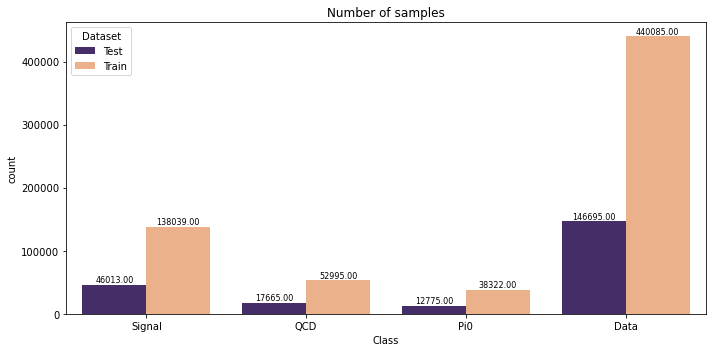

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=final_df, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])

for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")

In [31]:
ClassColors = Conf.ClassColors

In [32]:
def MyBins(lower,upper,step): return np.arange(lower,upper,step).tolist() 
def prGreen(prt): print("\033[92m {}\033[00m" .format(prt))


def MakeFeaturePlots(df_final,features,feature_bins,Set="Train",OutputDirName='Figures',cat='Category',label=[""],weight="NewWt",log=False,locate=[""]):
    fig, axes = plt.subplots(1, len(features), figsize=(len(features)*5, 5))
    #fig, axes = plt.subplots(1, 1, figsize=(len(features)*5, 5))

    prGreen("Making "+Set+" dataset spectator plots")
    for m in range(len(features)):
        for i,group_df in df_final[df_final['Dataset'] == Set].groupby(cat):
            print(m, i, cat)
            group_df[features[m]].hist(histtype='step',color=ClassColors[i], bins=feature_bins[m], alpha=1,label=label[i], ax=axes[m], density=False, ls='-', weights =group_df[weight]/group_df[weight].sum(),linewidth=2)
        axes[m].legend(loc=locate[m])
        axes[m].set_xlabel(features[m])
        if log:
            axes[m].set_yscale("log")
            axes[m].set_ylim([0.0001,1.2])
        axes[m].set_title(features[m]+" ("+Set+" Dataset)")
        plt.savefig(OutputDirName+'/'+features[m]+Set+".png".format(m))




 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category


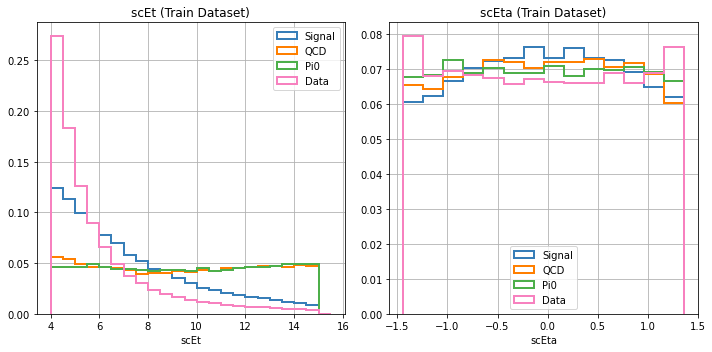

In [33]:
Variables=['scEt','scEta']
VarBins=[MyBins(4,16,0.5), MyBins(-1.44,1.44,0.2)]
loca=['upper right','lower center']
MakeFeaturePlots(final_df,Variables,VarBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=False,locate=loca)

 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category
2 0 Category
2 1 Category
2 2 Category
2 3 Category
3 0 Category
3 1 Category
3 2 Category
3 3 Category


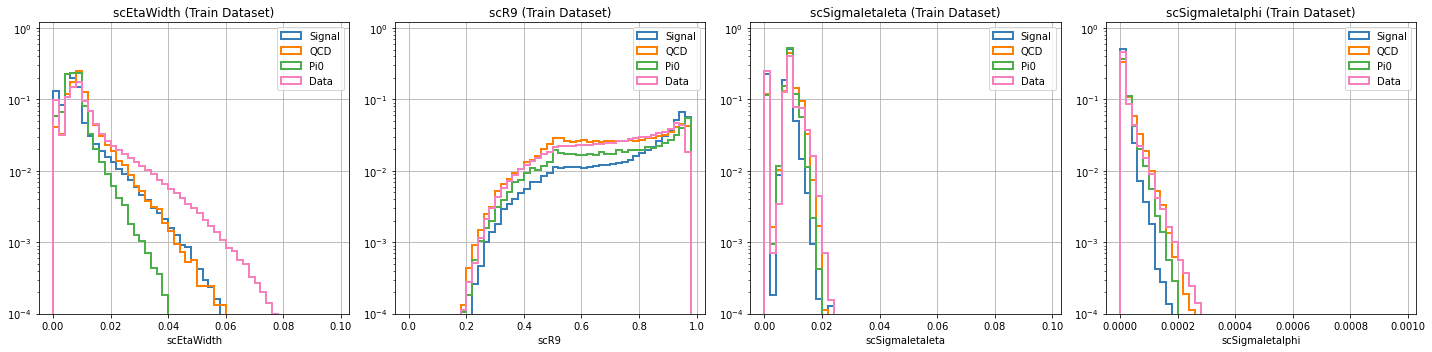

In [27]:
ShowerShape_widths=['scEtaWidth',
          'scR9',
          'scSigmaIetaIeta',
          'scSigmaIetaIphi']
VarBins=[MyBins(0,0.1,0.002), 
        MyBins(0,1,0.02), 
        MyBins(0,0.1,0.002),
        MyBins(0,0.001,0.00002)]
loca=['upper right']*4
MakeFeaturePlots(final_df,ShowerShape_widths,VarBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=True,locate=loca)

 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category
2 0 Category
2 1 Category
2 2 Category
2 3 Category
3 0 Category
3 1 Category
3 2 Category
3 3 Category


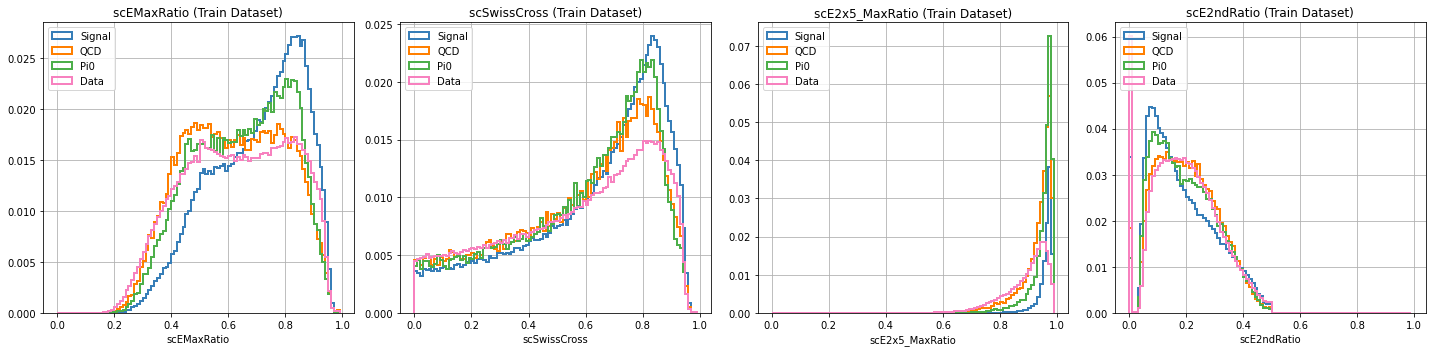

In [35]:
ShowerShape_Ratios=['scEMaxRatio',
          'scSwissCross',
          'scE2x5_MaxRatio',
          'scE2ndRatio']
VarBins=[MyBins(0,1,0.01)]*len(ShowerShape_Ratios)
loca=['upper left']*4
MakeFeaturePlots(final_df,ShowerShape_Ratios,VarBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=False,locate=loca)

 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category
2 0 Category
2 1 Category
2 2 Category
2 3 Category


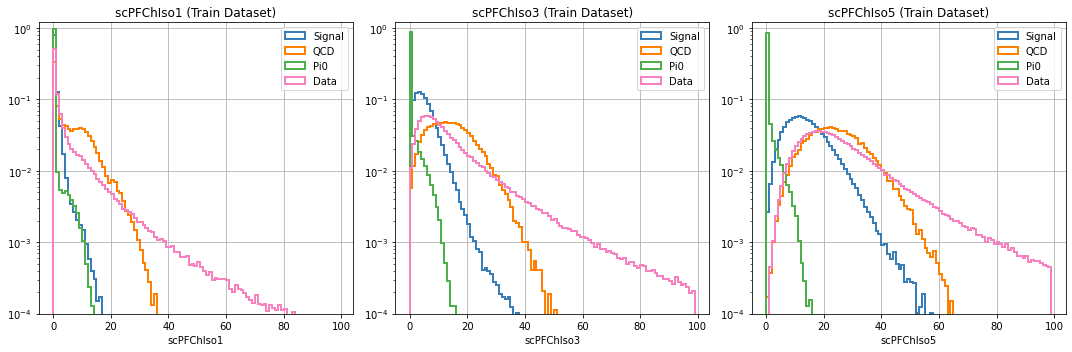

In [36]:
isolation_vars=['scPFChIso1','scPFChIso3','scPFChIso5']
VarBins=[MyBins(0,100,1)]*len(isolation_vars)
loca=['upper right']*3
MakeFeaturePlots(final_df,isolation_vars,VarBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=True,locate=loca)

## Reweighting 

In [37]:
import Tools.ptetaRwt as ptetaRwt

In [38]:
final_df.loc[TrainIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(final_df.loc[TrainIndices],"Class",
                                                   #ptw=[4,6,8,10,13,15],etaw=[-2.4,-2.0,-1.566,1.566,2.0,2.4],
                                                   ptw=Conf.ptbins,etaw=Conf.etabins,
                                                   pt='scEt',eta='scEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="Signal",Classes=Classes)

final_df.loc[TestIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(final_df.loc[TestIndices],"Class",
                                                   #ptw=[4,6,8,10,13,15],etaw=[-2.4,-2.0,-1.566,1.566,2.0,2.4],
                                                   #ptw=[4,6,8,10,13,15],etaw=[-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442],
                                                   ptw=Conf.ptbins,etaw=Conf.etabins,
                                                   pt='scEt',eta='scEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="Signal",Classes=Classes)

Number of xsec events in bkg for pt 4 to 6 before  weighing = 1166
Number of xsec events in signal for pt 4 to 6 before  weighing = 5766
Number of xsec events in bkg for pt 4 to 6 before  weighing = 757
Number of xsec events in signal for pt 4 to 6 before  weighing = 5766
Number of xsec events in bkg for pt 4 to 6 before  weighing = 38454
Number of xsec events in signal for pt 4 to 6 before  weighing = 5766
Number of xsec events in bkg for pt 6 to 8 before  weighing = 1030
Number of xsec events in signal for pt 6 to 8 before  weighing = 3863
Number of xsec events in bkg for pt 6 to 8 before  weighing = 796
Number of xsec events in signal for pt 6 to 8 before  weighing = 3863
Number of xsec events in bkg for pt 6 to 8 before  weighing = 10215
Number of xsec events in signal for pt 6 to 8 before  weighing = 3863
Number of xsec events in bkg for pt 8 to 10 before  weighing = 949
Number of xsec events in signal for pt 8 to 10 before  weighing = 2183
Number of xsec events in bkg for pt 8 to

Number of xsec events in bkg for pt 4 to 6 before  weighing = 2084
Number of xsec events in signal for pt 4 to 6 before  weighing = 11173
Number of xsec events in bkg for pt 4 to 6 before  weighing = 1312
Number of xsec events in signal for pt 4 to 6 before  weighing = 11173
Number of xsec events in bkg for pt 4 to 6 before  weighing = 48359
Number of xsec events in signal for pt 4 to 6 before  weighing = 11173
Number of xsec events in bkg for pt 6 to 8 before  weighing = 1654
Number of xsec events in signal for pt 6 to 8 before  weighing = 6547
Number of xsec events in bkg for pt 6 to 8 before  weighing = 1166
Number of xsec events in signal for pt 6 to 8 before  weighing = 6547
Number of xsec events in bkg for pt 6 to 8 before  weighing = 13531
Number of xsec events in signal for pt 6 to 8 before  weighing = 6547
Number of xsec events in bkg for pt 8 to 10 before  weighing = 1588
Number of xsec events in signal for pt 8 to 10 before  weighing = 3823
Number of xsec events in bkg for p

Number of events in QCD after  weighing = 138039.0
Number of events in Pi0 after  weighing = 138039.0
Number of events in Data after  weighing = 138038.99999999997
Number of xsec events in bkg for pt 4 to 6 before  weighing = 433
Number of xsec events in signal for pt 4 to 6 before  weighing = 1980
Number of xsec events in bkg for pt 4 to 6 before  weighing = 233
Number of xsec events in signal for pt 4 to 6 before  weighing = 1980
Number of xsec events in bkg for pt 4 to 6 before  weighing = 13113
Number of xsec events in signal for pt 4 to 6 before  weighing = 1980
Number of xsec events in bkg for pt 6 to 8 before  weighing = 325
Number of xsec events in signal for pt 6 to 8 before  weighing = 1340
Number of xsec events in bkg for pt 6 to 8 before  weighing = 265
Number of xsec events in signal for pt 6 to 8 before  weighing = 1340
Number of xsec events in bkg for pt 6 to 8 before  weighing = 3446
Number of xsec events in signal for pt 6 to 8 before  weighing = 1340
Number of xsec ev

Number of xsec events in bkg for pt 4 to 6 before  weighing = 658
Number of xsec events in signal for pt 4 to 6 before  weighing = 3736
Number of xsec events in bkg for pt 4 to 6 before  weighing = 445
Number of xsec events in signal for pt 4 to 6 before  weighing = 3736
Number of xsec events in bkg for pt 4 to 6 before  weighing = 16309
Number of xsec events in signal for pt 4 to 6 before  weighing = 3736
Number of xsec events in bkg for pt 6 to 8 before  weighing = 540
Number of xsec events in signal for pt 6 to 8 before  weighing = 2258
Number of xsec events in bkg for pt 6 to 8 before  weighing = 394
Number of xsec events in signal for pt 6 to 8 before  weighing = 2258
Number of xsec events in bkg for pt 6 to 8 before  weighing = 4474
Number of xsec events in signal for pt 6 to 8 before  weighing = 2258
Number of xsec events in bkg for pt 8 to 10 before  weighing = 520
Number of xsec events in signal for pt 8 to 10 before  weighing = 1307
Number of xsec events in bkg for pt 8 to 10

Number of events in Signal after  weighing = 46013.0
Number of events in QCD after  weighing = 46013.0
Number of events in Pi0 after  weighing = 46013.0
Number of events in Data after  weighing = 46013.00000000001


In [26]:
final_df['NewWt'].unique()

array([1.        , 1.16173032, 5.72657055, 0.63544588, 2.4135255 ,
       0.5799458 , 5.42636986, 1.13154831, 4.57274827, 1.19314206,
       5.5696913 , 2.30031612, 5.36132438, 5.26525424, 0.61665053,
       3.61303462, 1.08364312, 1.1566416 , 2.41830823, 2.39976959,
       2.40743073, 3.95828295, 2.46875   , 2.30409357, 0.61403509,
       5.80978261, 0.63142857, 3.81818182, 0.625     , 3.75048544,
       0.62315996, 1.20323625, 2.41831683, 1.15767635, 0.58609272,
       3.89216684, 2.26238145, 0.61306533, 5.17626527, 5.47619048,
       1.17434472, 5.58362369, 4.94511149, 0.58640777, 1.18533071,
       1.15671642, 1.24657534, 1.18762887, 4.18148148, 5.67781155,
       2.38771186, 5.14106145, 1.8559322 , 4.29028698, 4.91504854,
       3.89963504, 0.63035019, 0.76902174, 0.62875341, 2.51346154,
       2.35962145, 3.95264117, 2.19266055, 3.70491803, 3.76082677,
       1.19563736, 2.24761905, 3.94303797, 3.78106509, 5.73913043,
       1.12055336, 1.2642998 , 1.29376499, 4.12307692, 3.59442

Text(0.5, 1.0, 'Number of samples')

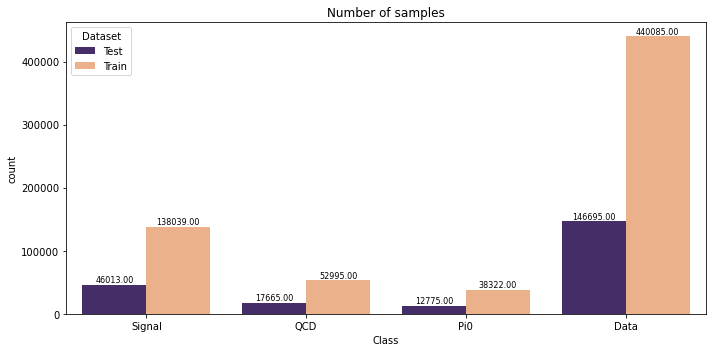

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=final_df, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])

for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")

 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category


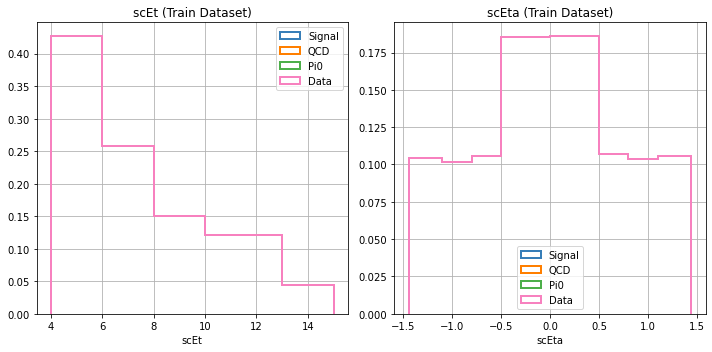

In [42]:
Variables=['scEt','scEta']
#VarBins=[[4,6,8,10,13,15], [-2.4,-2.0,-1.566,1.566,2.0,2.4]]
VarBins=[Conf.ptbins,Conf.etabins]
loca=['upper right','lower center']
MakeFeaturePlots(final_df,Variables,VarBins,Set="Train",OutputDirName=Conf.OutputDirName+"/reweighted",label=Classes,log=False,locate=loca)

## Define MVA parameters as a dictionary 

In [29]:
import pickle
import multiprocessing
import seaborn as sns

In [30]:
MVA = {"MVAtype":"XGB_1", #Keyword to identify MVA method.
     "Color":"green", #Plot color for MVA
     "Label":"XGB small list", # label can be anything (this is how you will identify them on plot legends)
     "features":['scEtaWidth','scR9','scSigmaIetaIeta','scSigmaIetaIphi','scEMaxRatio','scSwissCross','scE2x5_MaxRatio','scE2ndRatio','scPFChIso1','scPFChIso3','scPFChIso5'],
     "feature_bins":[MyBins(0,0.1,0.001), MyBins(0,1,0.01), MyBins(0,0.1,0.001),MyBins(0,0.002,0.00001),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01), 
                    MyBins(0,100,1),MyBins(0,100,1),MyBins(0,100,1)], #same length as features #Binning used only for plotting features (should be in the same order as features), 
     'Scaler':"StandardScaler", #Scaling for features before passing to the model training
     'UseGPU':False, #If you have a GPU card, you can turn on this option (CUDA 10.0, Compute Capability 3.5 required)
     "XGBGridSearch":{'colsample_bytree': [0.5,1.0], 'gamma': [0.5], 'max_depth': [5,3], 'min_child_weight': [5], 'subsample': [0.8]}
      }

os.system("mkdir -p " + Conf.OutputDirName+"/"+MVA["MVAtype"])

0

In [31]:
def corre(df,Classes=[''],MVA={}):
    for C in Classes:
            for k in ["Train","Test"]:
                fig, axes = plt.subplots(1, 1, figsize=(len(MVA["features"]), len(MVA["features"])))
                cor = df.loc[(df['Dataset'] == k) & (df['Class'] == str(C))][MVA["features"]].corr()
                sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,ax=axes,annot_kws={"size":len(MVA["features"])/4})
                axes.tick_params(axis='x', labelsize=len(MVA["features"]))
                axes.tick_params(axis='y', labelsize=len(MVA["features"]))
                
                fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"_"+C+"_CORRELATION_"+k+".png")
                fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"_"+C+"_CORRELATION_"+k+".pdf")

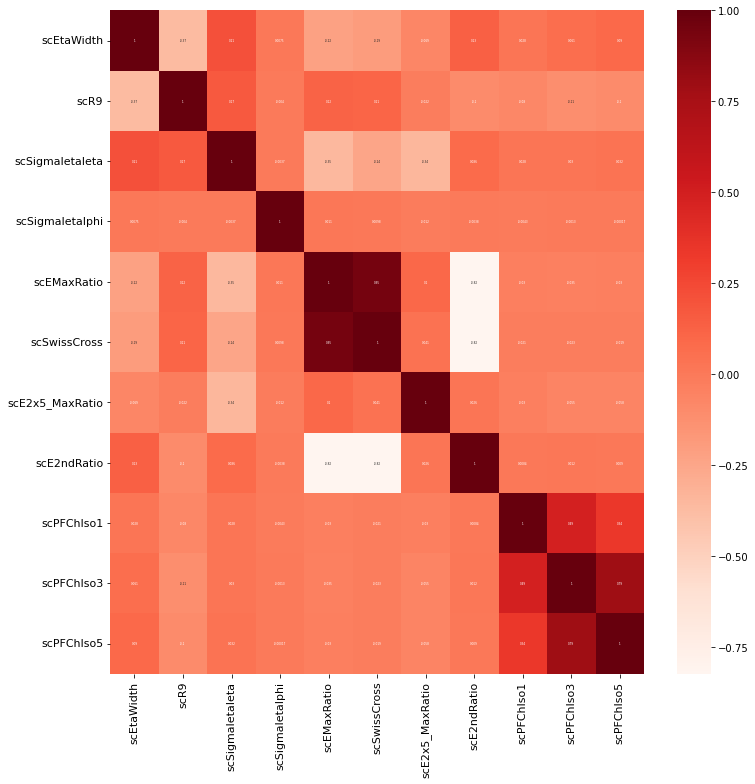

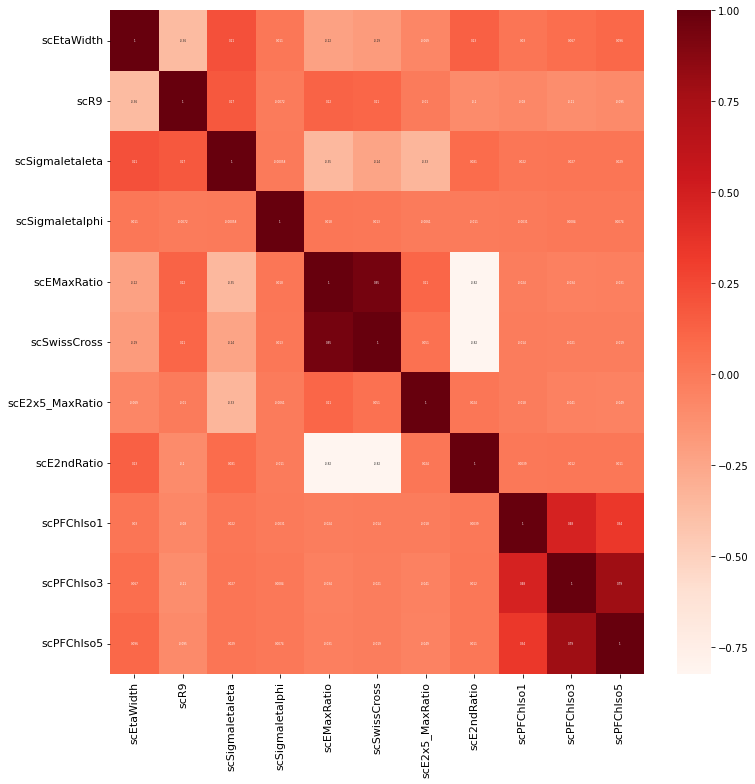

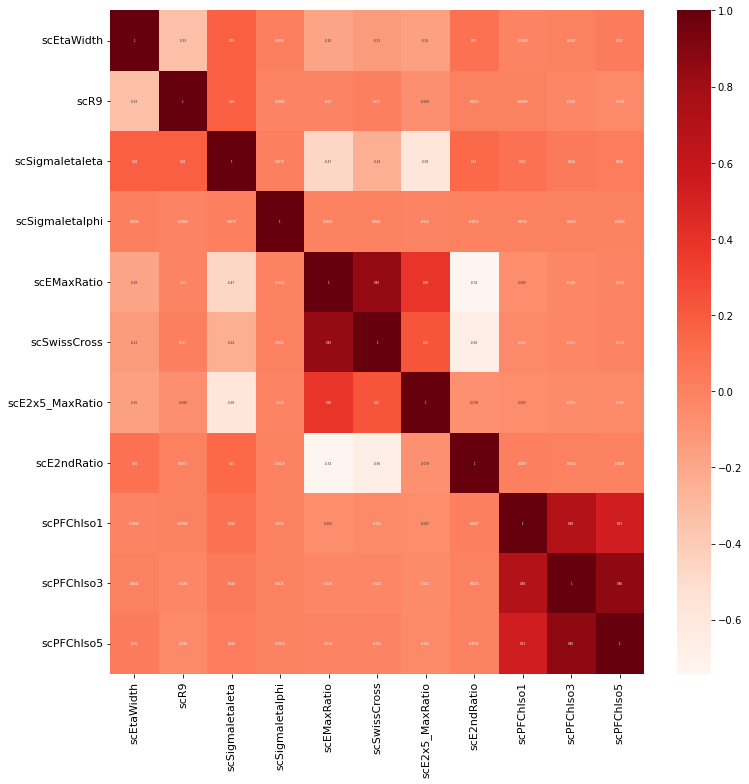

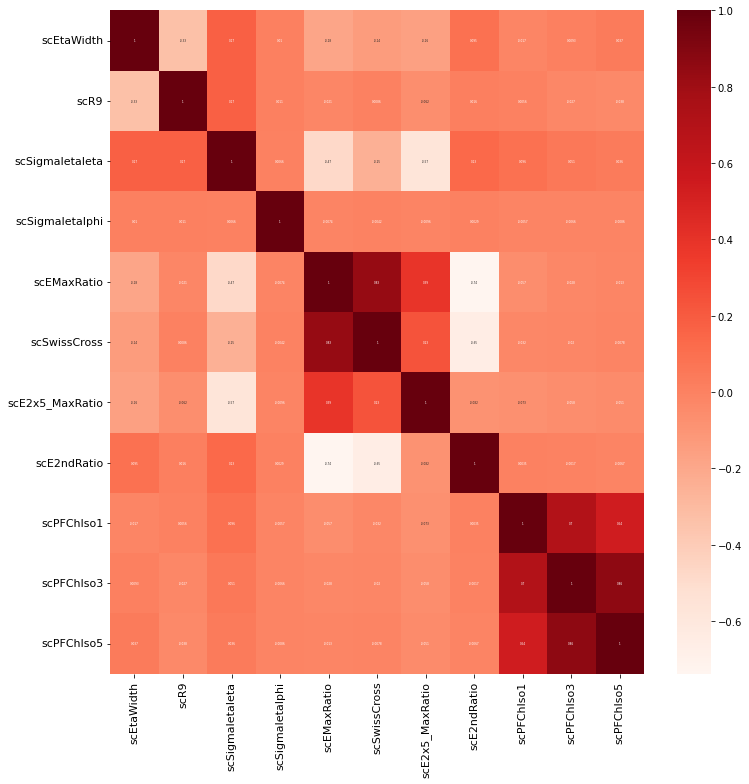

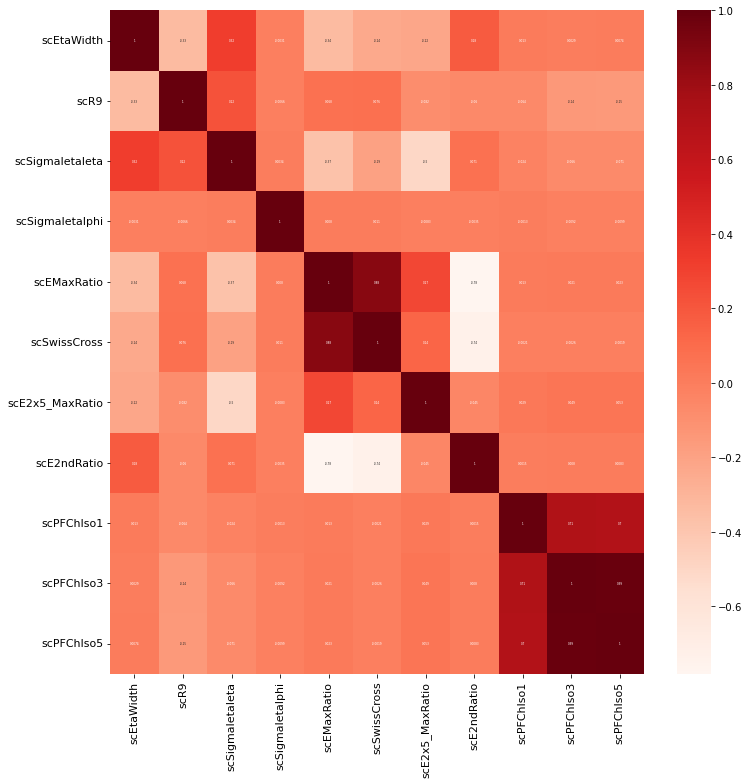

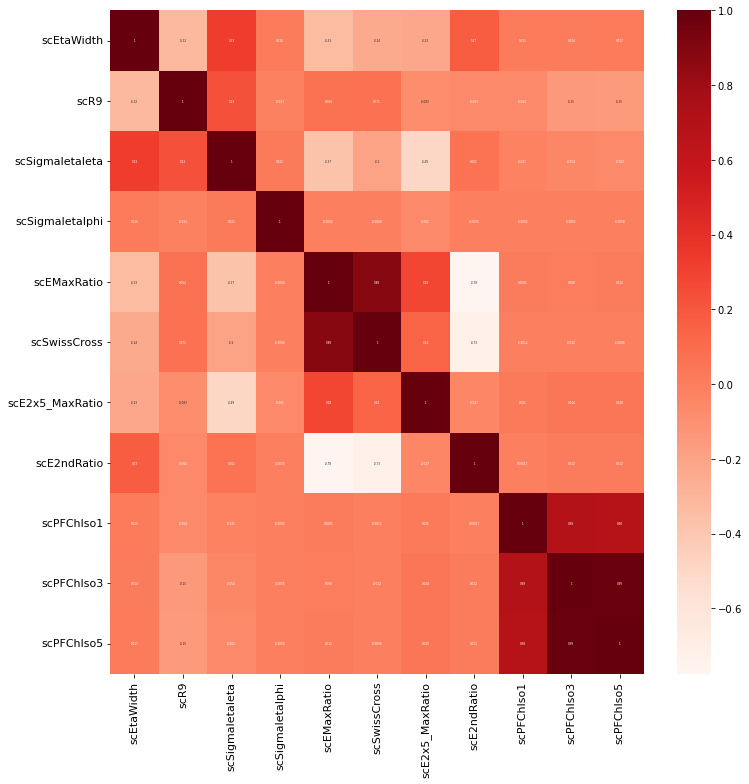

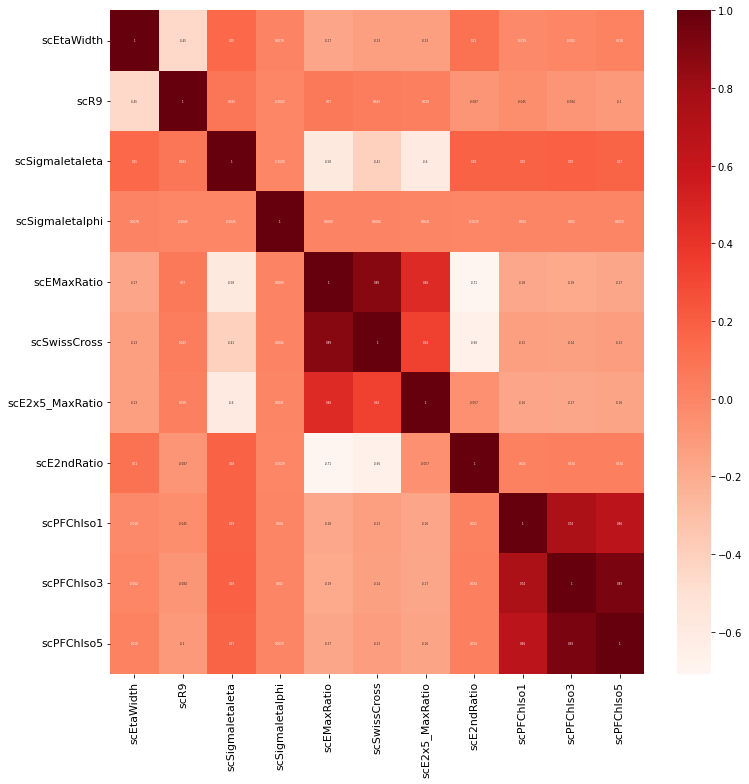

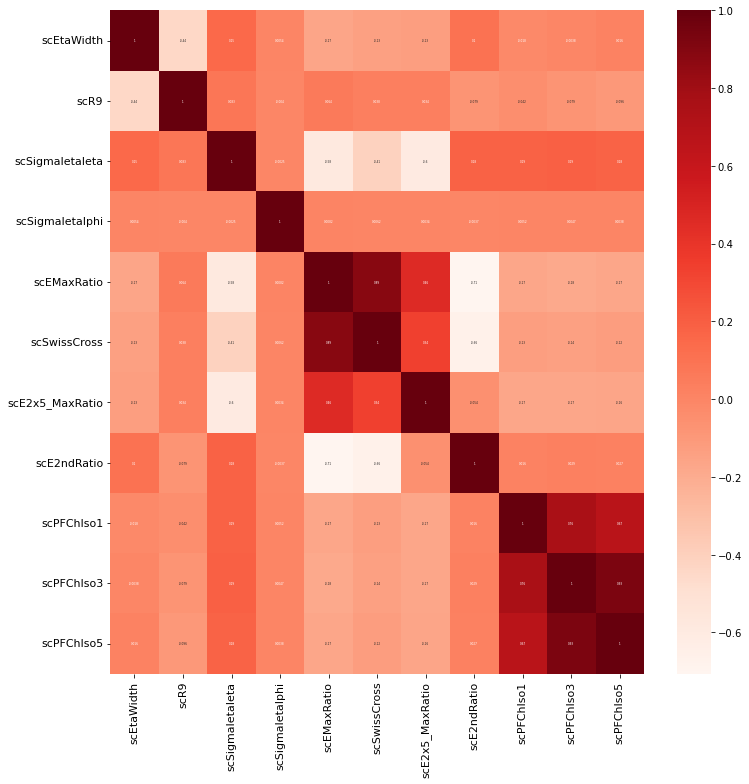

In [32]:
corre(final_df,Classes,MVA)

In [33]:
#MakeFeaturePlots(final_df,MVA["features"],MVA["feature_bins"],Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=True)

## Data preparation 

In [34]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]

    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)

## XGBoost training

In [35]:
'''
def runXGBTraining(df_final,TrainIndices,TestIndices,MVA,Scaler,cat,weight="NewWt"):
    X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)
    exec("from sklearn.preprocessing import "+MVA["Scaler"])
    exec("sc = "+MVA["Scaler"]+"()")
    #scale the training data input features so that it is between 0 and 1
    X_train = Scaler.fit_transform(X_train) 
    X_test = Scaler.transform(X_test)
    
    import xgboost as xgb
    from sklearn.model_selection import cross_val_score, GridSearchCV
    eval_s = [(X_train, Y_train),(X_test,Y_test)]
    if "UseGPU" in MVA and MVA["UseGPU"]:
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= 'gpu_hist',random_state=42)
    else:
        xgb_model = xgb.XGBClassifier(objective="binary:logistic",random_state=42)
    cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],scoring='neg_log_loss',cv=3,verbose=1)
    search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=0,eval_set=eval_s)
    prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
    prGreen("XGB Best Parameters")
    prGreen(str(search.best_params_))
    fig, ax = plt.subplots()
    ax.barh(MVA["features"],cv.best_estimator_.feature_importances_)
    ax.set_xlabel("Xgboost Feature Importance")
    
    return X_train, Y_train, Wt_train, X_test, Y_test, Wt_test,cv, search
'''

'\ndef runXGBTraining(df_final,TrainIndices,TestIndices,MVA,Scaler,cat,weight="NewWt"):\n    X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)\n    exec("from sklearn.preprocessing import "+MVA["Scaler"])\n    exec("sc = "+MVA["Scaler"]+"()")\n    #scale the training data input features so that it is between 0 and 1\n    X_train = Scaler.fit_transform(X_train) \n    X_test = Scaler.transform(X_test)\n    \n    import xgboost as xgb\n    from sklearn.model_selection import cross_val_score, GridSearchCV\n    eval_s = [(X_train, Y_train),(X_test,Y_test)]\n    if "UseGPU" in MVA and MVA["UseGPU"]:\n        xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= \'gpu_hist\',random_state=42)\n    else:\n        xgb_model = xgb.XGBClassifier(objective="binary:logistic",random_state=42)\n    cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],scoring=\'neg_log_loss\',cv=3,verbose=1)\n    search=cv.fit(

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Category', ylabel='count'>

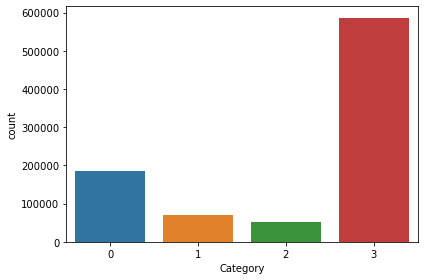

In [36]:
sns.countplot(final_df['Category'])

# prepare dataset

In [37]:
X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(final_df,TrainIndices,TestIndices,MVA["features"],cat='Category',weight="NewWt")
exec("from sklearn.preprocessing import "+MVA["Scaler"])
exec("sc = "+MVA["Scaler"]+"()")
#scale the training data input features so that it is between 0 and 1
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)
pickle.dump(sc, open(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"_scaler.pkl",'wb'))

## Run the training

Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Expected neg log loss of XGB model = -83.2%
 XGB Best Parameters
 {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}
Execution time is 3521.6458599567413


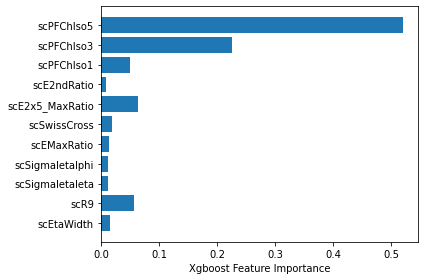

In [38]:
start = time.time()


    
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV
eval_s = [(X_train, Y_train),(X_test,Y_test)]

#if "UseGPU" in MVA and MVA["UseGPU"]:
 #   xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= 'gpu_hist',random_state=42)
#else:
xgb_model = xgb.XGBClassifier(objective="multi:softmax",random_state=42,num_class=4)

cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],scoring='neg_log_loss',cv=3,verbose=1)
search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=0,eval_set=eval_s)
pickle.dump(cv, open(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"modelXGB.pkl", "wb"))
prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
prGreen("XGB Best Parameters")
prGreen(str(search.best_params_))
fig, ax = plt.subplots()
ax.barh(MVA["features"],cv.best_estimator_.feature_importances_)
ax.set_xlabel("Xgboost Feature Importance")

#X_train, Y_train, Wt_train, X_test, Y_test, Wt_test, cv, search=runXGBTraining(final_df,TrainIndices,TestIndices,MVA,sc,cat='Category',weight="NewWt")

end = time.time()
print("Execution time is", end-start)

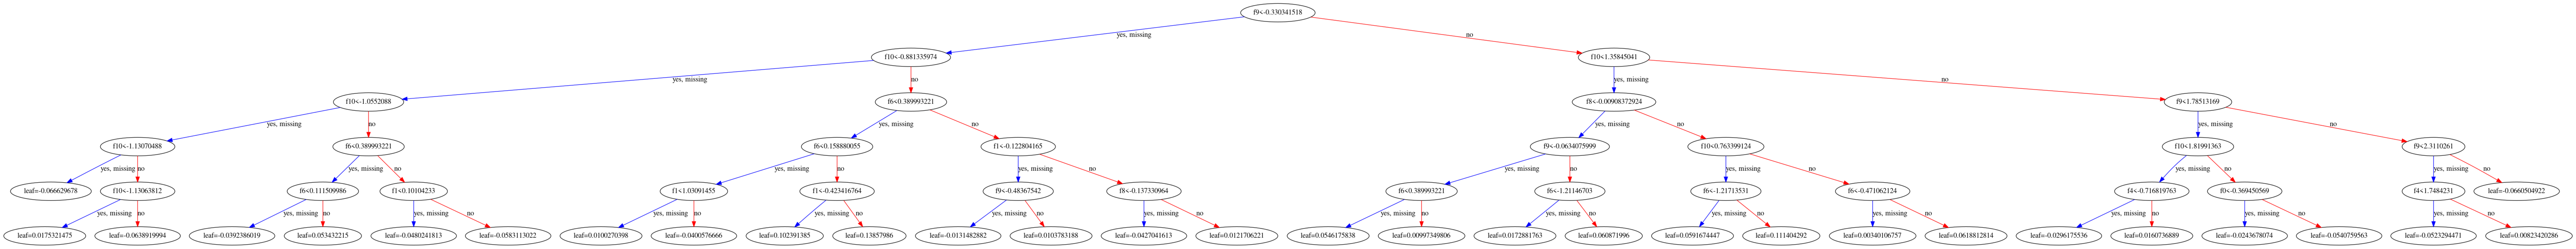

In [39]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 28,12

plot_tree(cv.best_estimator_, num_trees=1)
fig = mpl.pyplot.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [40]:
#from xgboost import plot_tree
#plot_tree(booster=search,trees=1)
#plt.show()

## Diagnostic error plot 

In [41]:
results = cv.best_estimator_.evals_result()


In [42]:
print(results)

{'validation_0': {'merror': [0.526869, 0.531082, 0.526178, 0.522805, 0.524343, 0.532791, 0.528898, 0.5239, 0.523753, 0.522288, 0.52119, 0.519795, 0.518999, 0.516594, 0.51451, 0.511545, 0.511808, 0.510634, 0.50732, 0.506887, 0.504557, 0.504297, 0.50289, 0.500131, 0.49911, 0.497515, 0.496326, 0.49377, 0.492866, 0.49079, 0.489671, 0.488781, 0.487583, 0.48592, 0.484548, 0.48353, 0.482262, 0.481691, 0.480511, 0.47888, 0.477842, 0.477122, 0.476357, 0.47531, 0.474015, 0.47386, 0.472763, 0.471075, 0.470407, 0.469774, 0.468642, 0.467875, 0.466659, 0.465978, 0.465308, 0.464927, 0.464308, 0.463993, 0.463647, 0.462743, 0.462075, 0.461799, 0.461425, 0.460817, 0.46043, 0.459701, 0.45928, 0.458772, 0.458424, 0.457851, 0.457483, 0.456954, 0.456602, 0.456243, 0.455819, 0.455659, 0.455407, 0.455002, 0.45467, 0.45424, 0.454168, 0.45378, 0.453259, 0.45296, 0.45272, 0.452185, 0.452207, 0.451926, 0.45168, 0.451393, 0.451085, 0.450981, 0.450712, 0.4503, 0.450226, 0.449934, 0.449536, 0.449211, 0.448698, 0.448

Text(0.5, 1.0, 'XGB small list XGBoost Error')

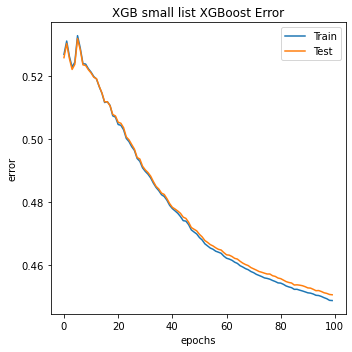

In [43]:
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(5,5))
        
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
ax.set_ylabel('error')
ax.set_xlabel('epochs')
ax.set_title(MVA["Label"]+' XGBoost Error')

In [44]:
from tensorflow.keras.utils import to_categorical
y_test_pred=cv.predict_proba(X_test)
y_train_pred=cv.predict_proba(X_train)

Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)

In [45]:
y_train_pred

array([[0.7615189 , 0.01689983, 0.17885034, 0.04273098],
       [0.37484568, 0.19377874, 0.00143247, 0.42994305],
       [0.5201411 , 0.15759599, 0.00129021, 0.32097268],
       ...,
       [0.40571138, 0.2265729 , 0.00126764, 0.3664481 ],
       [0.20472734, 0.39630702, 0.00166519, 0.39730048],
       [0.8671069 , 0.03633345, 0.02059457, 0.07596504]], dtype=float32)

In [46]:
final_df.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_train)[:,0]
final_df.loc[TestIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_test)[:,0]

In [47]:
final_df

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category,NewWt,xsecwt,Dataset,TrainDataset,XGB_1_pred
0,7.753203,6.792725,0.525711,1.196866,0.003998,1.000000e+09,0.0,0.658708,0.009202,0.000000e+00,0.915197,0.907339,1.000000,0.084803,6.091204,6.091204,6.091204,6.091204,6.091204,0.000000,3.246895,3.246895,4.601000,8.016312,Signal,0,1.000000,1,Test,0.0,0.584634
1,10.727509,10.485172,-0.214587,-2.308056,0.008042,1.000000e+09,0.0,1.000000,0.008907,8.288317e-07,0.393128,-0.279215,1.000000,0.293671,0.000000,0.332892,1.092775,1.092775,2.232820,0.000000,0.623293,2.910528,6.503263,7.525467,Signal,0,1.000000,1,Train,1.0,0.842360
2,9.719466,9.167964,-0.345143,-1.720641,0.004737,1.000000e+09,0.0,1.000000,0.009747,1.701725e-06,0.889623,0.875929,0.974408,0.049591,0.000000,0.640867,2.352639,2.352639,3.793797,0.000000,2.969234,4.879227,12.608646,17.172276,Signal,0,1.000000,1,Train,1.0,0.856289
3,8.638324,8.251705,0.304932,-1.335767,0.004465,2.583050e+00,0.0,1.000000,0.008106,-7.329957e-06,0.876202,0.858711,1.000000,0.071302,7.805819,7.805819,7.805819,7.805819,10.001609,0.329437,0.329437,2.909377,4.027423,5.611387,Signal,0,1.000000,1,Train,1.0,0.897428
4,7.175752,6.075890,-0.592973,0.308302,0.004411,1.000000e+09,0.0,0.947147,0.000000,0.000000e+00,0.590617,0.306855,1.000000,0.409383,5.758420,5.758420,6.070301,6.887314,7.134089,1.194138,1.478183,2.034288,3.374829,4.842720,Signal,0,1.000000,1,Train,1.0,0.854324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892584,9.780547,5.306043,1.221341,-1.880710,0.026531,2.474406e+00,0.0,0.802411,0.000000,0.000000e+00,0.893722,0.881084,1.000000,0.106278,0.000000,2.514176,3.644151,6.149338,7.438563,0.000000,3.998085,9.424127,19.662426,28.492504,Data,3,0.155753,1,Train,1.0,0.290094
892585,7.746019,4.496956,-1.139436,0.032172,0.030937,2.058212e+00,0.0,0.896276,0.008749,2.913063e-06,0.339762,-0.301056,1.000000,0.227068,3.733668,5.868949,6.675651,9.498166,9.498166,0.000000,5.032837,8.638511,13.459010,23.742529,Data,3,0.149945,1,Train,1.0,0.432178
892586,4.343835,4.000843,-0.411174,-0.092970,0.009358,1.421361e+00,0.0,0.737303,0.009832,4.874503e-05,0.706667,0.799411,0.999366,0.150949,2.921132,15.264672,20.183823,21.466429,26.813873,1.258121,8.295094,20.360811,30.528915,40.476631,Data,3,0.230215,1,Train,1.0,0.022023
892587,5.897676,5.636772,-0.303095,-0.276624,0.008719,1.426615e+00,0.0,0.549528,0.008057,-2.774896e-05,0.518012,0.069542,1.000000,0.308857,13.513885,18.355679,19.518768,22.469543,23.245632,0.759887,6.259492,9.399844,27.299101,37.837360,Data,3,0.230215,1,Train,1.0,0.238934


In [48]:
plotwt_train=np.asarray(final_df.loc[TrainIndices,'xsecwt'])
plotwt_test=np.asarray(final_df.loc[TestIndices,'xsecwt'])

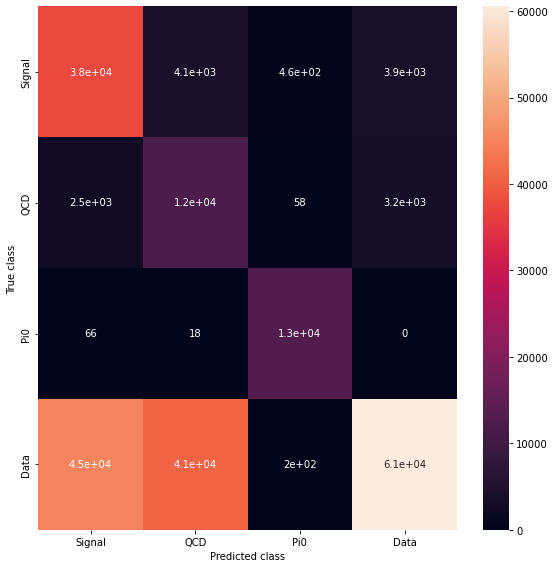

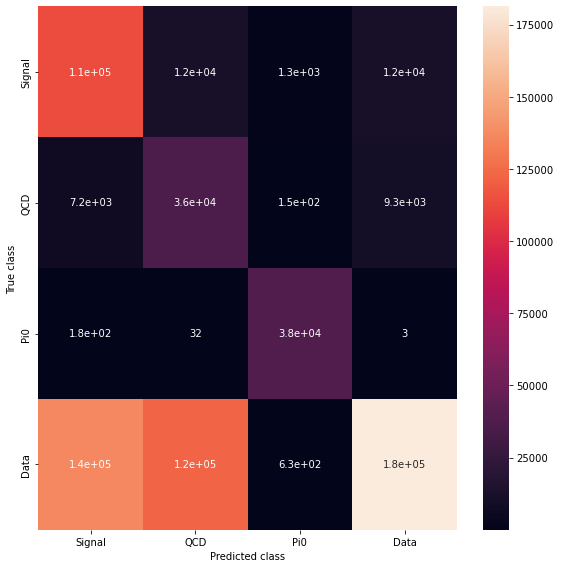

In [49]:
import pandas as pd

from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_test.argmax(axis=1), y_test_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes, columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")

fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_train.argmax(axis=1), y_train_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes,columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")
fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"CM_Training.png") 

In [51]:
final_df

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category,NewWt,xsecwt,Dataset,TrainDataset,XGB_1_pred
0,7.753203,6.792725,0.525711,1.196866,0.003998,1.000000e+09,0.0,0.658708,0.009202,0.000000e+00,0.915197,0.907339,1.000000,0.084803,6.091204,6.091204,6.091204,6.091204,6.091204,0.000000,3.246895,3.246895,4.601000,8.016312,Signal,0,1.000000,1,Test,0.0,0.584634
1,10.727509,10.485172,-0.214587,-2.308056,0.008042,1.000000e+09,0.0,1.000000,0.008907,8.288317e-07,0.393128,-0.279215,1.000000,0.293671,0.000000,0.332892,1.092775,1.092775,2.232820,0.000000,0.623293,2.910528,6.503263,7.525467,Signal,0,1.000000,1,Train,1.0,0.842360
2,9.719466,9.167964,-0.345143,-1.720641,0.004737,1.000000e+09,0.0,1.000000,0.009747,1.701725e-06,0.889623,0.875929,0.974408,0.049591,0.000000,0.640867,2.352639,2.352639,3.793797,0.000000,2.969234,4.879227,12.608646,17.172276,Signal,0,1.000000,1,Train,1.0,0.856289
3,8.638324,8.251705,0.304932,-1.335767,0.004465,2.583050e+00,0.0,1.000000,0.008106,-7.329957e-06,0.876202,0.858711,1.000000,0.071302,7.805819,7.805819,7.805819,7.805819,10.001609,0.329437,0.329437,2.909377,4.027423,5.611387,Signal,0,1.000000,1,Train,1.0,0.897428
4,7.175752,6.075890,-0.592973,0.308302,0.004411,1.000000e+09,0.0,0.947147,0.000000,0.000000e+00,0.590617,0.306855,1.000000,0.409383,5.758420,5.758420,6.070301,6.887314,7.134089,1.194138,1.478183,2.034288,3.374829,4.842720,Signal,0,1.000000,1,Train,1.0,0.854324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892584,9.780547,5.306043,1.221341,-1.880710,0.026531,2.474406e+00,0.0,0.802411,0.000000,0.000000e+00,0.893722,0.881084,1.000000,0.106278,0.000000,2.514176,3.644151,6.149338,7.438563,0.000000,3.998085,9.424127,19.662426,28.492504,Data,3,0.155753,1,Train,1.0,0.290094
892585,7.746019,4.496956,-1.139436,0.032172,0.030937,2.058212e+00,0.0,0.896276,0.008749,2.913063e-06,0.339762,-0.301056,1.000000,0.227068,3.733668,5.868949,6.675651,9.498166,9.498166,0.000000,5.032837,8.638511,13.459010,23.742529,Data,3,0.149945,1,Train,1.0,0.432178
892586,4.343835,4.000843,-0.411174,-0.092970,0.009358,1.421361e+00,0.0,0.737303,0.009832,4.874503e-05,0.706667,0.799411,0.999366,0.150949,2.921132,15.264672,20.183823,21.466429,26.813873,1.258121,8.295094,20.360811,30.528915,40.476631,Data,3,0.230215,1,Train,1.0,0.022023
892587,5.897676,5.636772,-0.303095,-0.276624,0.008719,1.426615e+00,0.0,0.549528,0.008057,-2.774896e-05,0.518012,0.069542,1.000000,0.308857,13.513885,18.355679,19.518768,22.469543,23.245632,0.759887,6.259492,9.399844,27.299101,37.837360,Data,3,0.230215,1,Train,1.0,0.238934


In [52]:
y_test_pred[:,0][Y_test[:,0]==1]

array([0.42583415, 0.73457664, 0.7474716 , ..., 0.8347617 , 0.286641  ,
       0.1759958 ], dtype=float32)

In [53]:
[Y_test[:,0]==1]

[array([ True,  True,  True, ..., False, False, False])]

In [54]:
plotwt_test[Y_test[:,0]==1]/np.sum(plotwt_test[Y_test[:, 0]==1])

array([2.17329885e-05, 2.17329885e-05, 2.17329885e-05, ...,
       2.17329885e-05, 2.17329885e-05, 2.17329885e-05])

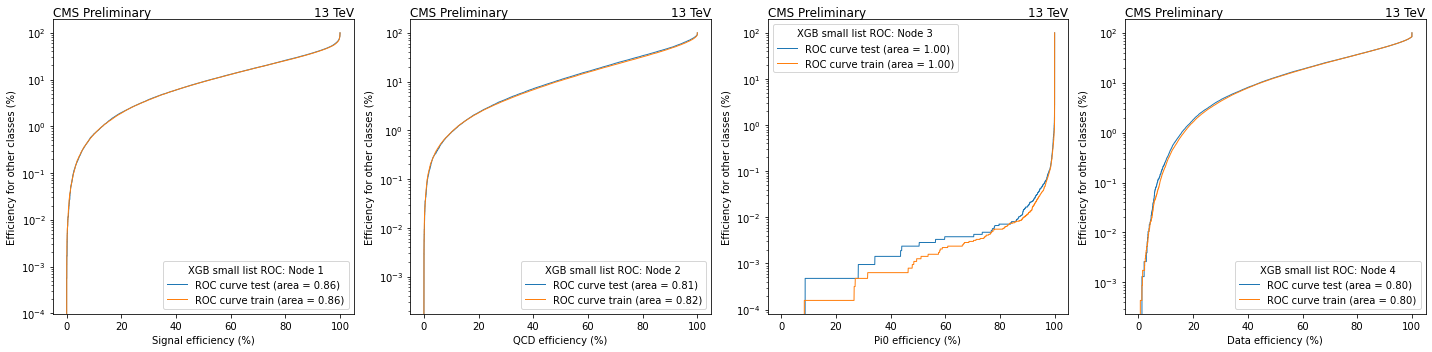

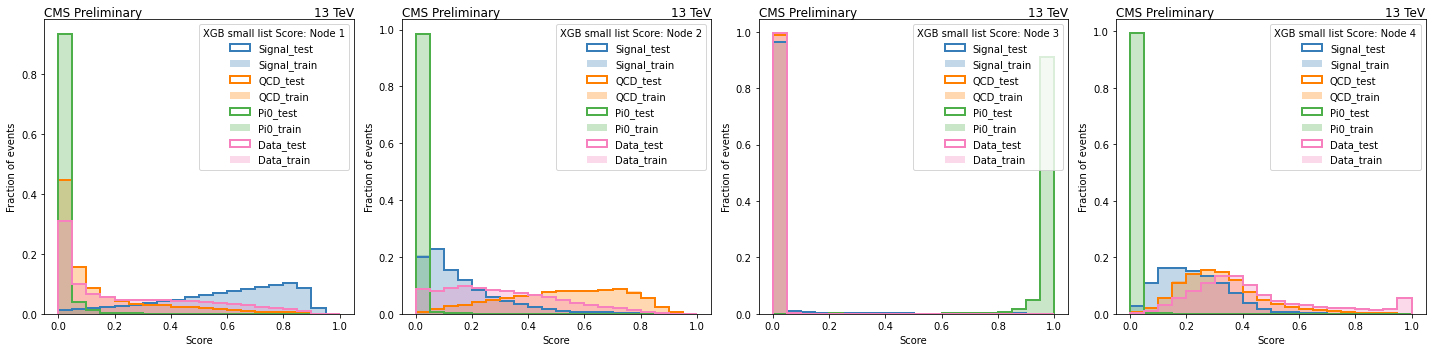

In [55]:
from sklearn.metrics import roc_curve, auc

n_classes=len(Classes)
fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))
figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))    
for i in range(n_classes):
    axMVA=axesMVA[i]
    ax=axes[i]
    for k in range(n_classes):
        axMVA.hist(y_test_pred[:, i][Y_test[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_test',
                   weights=plotwt_test[Y_test[:, k]==1]/np.sum(plotwt_test[Y_test[:, k]==1]),
                   histtype='step',linewidth=2,color=ClassColors[k])
        axMVA.hist(y_train_pred[:, i][Y_train[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_train',
                   weights=plotwt_train[Y_train[:, k]==1]/np.sum(plotwt_train[Y_train[:, k]==1]),
                   histtype='stepfilled',alpha=0.3,linewidth=2,color=ClassColors[k])
        
    axMVA.set_xlabel('Score',fontsize=10)
        
    axMVA.set_ylabel('Fraction of events',fontsize=10)
    axMVA.legend(title=MVA["Label"]+' Score: Node '+str(i+1), loc="best",fontsize=10)
    axMVA.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=axMVA.transAxes, fontsize = 12)#, fontweight = 'bold')
        
    axMVA.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = axMVA.transAxes, fontsize = 12)
    #axMVA.set_yscale('log')
            
    fpr, tpr, th = roc_curve(Y_test[:, i], y_test_pred[:, i],sample_weight=plotwt_test)
    fpr_tr, tpr_tr, th_tr = roc_curve(Y_train[:, i], y_train_pred[:, i],sample_weight=plotwt_train)
    mask = tpr > 0.0
    fpr, tpr = fpr[mask], tpr[mask]

    mask = tpr_tr > 0.0
    fpr_tr, tpr_tr = fpr_tr[mask], tpr_tr[mask]

    roc_auc = auc(fpr, tpr)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
            
    ax.plot(tpr*100, fpr*100, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=1)
    ax.plot(tpr_tr*100, fpr_tr*100, label='ROC curve train (area = %0.2f)' % roc_auc_tr,linewidth=1)
    ax.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 12)#, fontweight = 'bold')
    ax.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 12)
    ax.set_yscale("log")
    ax.set_xlabel(Classes[i]+' efficiency (%)',fontsize=10)
    ax.set_ylabel('Efficiency for other classes (%)',fontsize=10)
    ax.legend(title=MVA["Label"]+' ROC: Node '+str(i+1),loc="best",fontsize=10)

fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"ROC.pdf")
fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"ROC.png")
figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"MVA.pdf")
figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"MVA.png")

## Advanced exercise 

In [56]:
import math
from uncertainties import ufloat
from uncertainties.umath import *

In [57]:
def eff(group_df,var,cat,catvalue):
    signalpass=len(group_df.query('('+var+' == 1) & ('+cat+' == '+str(catvalue)+')'))
    signalpass=ufloat(signalpass,math.sqrt(signalpass))
    signaltotal=len(group_df.query('('+cat+' == '+str(catvalue)+')'))
    signaltoal=ufloat(signaltotal,math.sqrt(signaltotal))
    if signaltotal>0:
        signaleff=(100*signalpass)/(signaltotal)
        return [signaleff.n, signaleff.s]
    else:
        print("Some bins have zero signal: assigning zero eff")
        return [0, 0]

def EffTrend(cat='',var='',groupbyvar='',ptbins=[],label='',title='',plotname='',df=pd.DataFrame(),plot_dir='',Classes=[''],Colors=['']):
    figMVAComp, axesComp = plt.subplots(1,1, figsize=(4, 4))
    ax=axesComp
    fulllist=[[] for i in range(len(Classes))]
    fullliste=[[[] for i in range(2)] for i in range(len(Classes))]
    #ptbinsmy=ptbins[:-1]
    ptbinsmy=[(ptbins[m+1]+ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        ptbinsmy[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*1.2
    #ptbinsmy.append(ptbins[len(ptbins)-1]*1.2)
    xefulllist=[(ptbins[m+1]-ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        xefulllist[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*0.2
    for i,group_df in df.groupby(groupbyvar):
        for k in range(len(Classes)):
            val=eff(group_df,var,cat,k)[0]
            vale=eff(group_df,var,cat,k)[1]
            fulllist[k].append(val)
            fullliste[k][0].append(vale)
            if val+vale<100:
                fullliste[k][1].append(vale)
            else:
                fullliste[k][1].append(100-val)
                
        
    for m in range(len(Classes)):
        if len(Classes)>2:
            if m==0 or m==1:
                marker='S'
            else:
                marker='B'
        if len(Classes)<3:
            if m==1:
                marker='S'
            else:
                marker='B'
        ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
    ax.set_ylim(0,130)
    if groupbyvar=='ele_pt_bin':
        #ax.set_yscale('log')
        ax.set_xlim(ptbins[0],ptbins[len(ptbins)-2]*1.4)
    #if groupbyvar=='ele_eta_bin':
        #ax.set_xlim(ptbins[0]*1.2,ptbins[len(ptbins)-1])
    ax.set_xlabel(label)
    ax.set_ylabel("Efficiency (%)")
    ax.set_title(title)
    ax.grid(True)
    #ax.legend(loc='best',ncol=2,bbox_to_anchor=(0., 1.1, 1., 0.2),fontsize=8)
    ax.legend(loc='best',ncol=2,fontsize=10)
    figMVAComp.savefig(plot_dir+plotname+".pdf")
    figMVAComp.savefig(plot_dir+plotname+".png")

## Efficiency studies at 80% and 90% working points

In [58]:
SigEffWPsi=["80%", "90%"]
MVAs=[MVA]
#ptbins = [4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,12,15]
#etabins = [-2.4,-2.2,-2.0,-1.8,-1.566,1.566,1.8,2.0,2.2,2.4]
#etabins = [-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442]
ptbins = Conf.ptbins
etabins = Conf.etabins
ptwtvar='scEt'
etawtvar='scEta'

In [59]:
cat='Category'

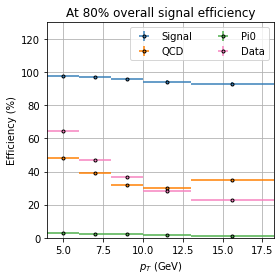

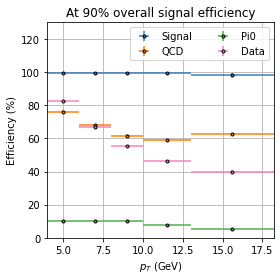

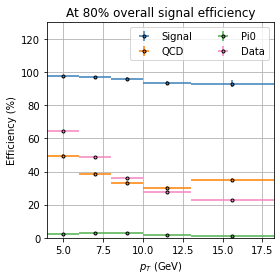

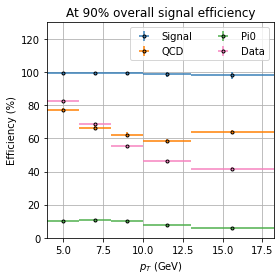

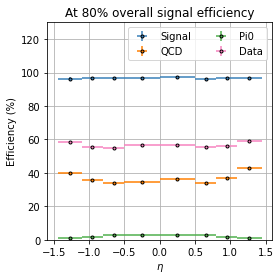

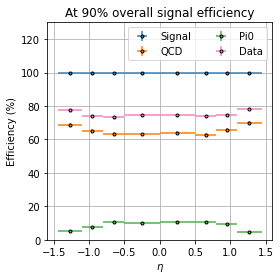

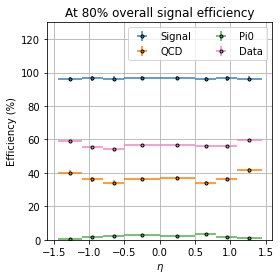

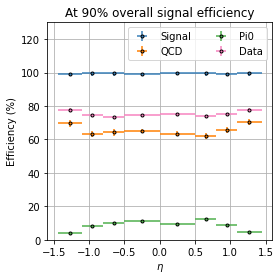

In [60]:
if len(SigEffWPsi)>0:
    PredMVAs=[]
    for MVA in MVAs:
        PredMVAs.append(MVA["MVAtype"]+'_pred')
    SigEffWPs=SigEffWPsi[:]
    for i,SigEffWPi in enumerate(SigEffWPs):
        SigEffWPs[i]=1-(int(SigEffWPi.replace('%', ''))/100)
    

    for MVA in MVAs:

        final_df["ele_pt_bin"] = pd.cut(final_df[ptwtvar], bins=ptbins, labels=list(range(len(ptbins)-1)))
        final_df["ele_eta_bin"] = pd.cut(final_df[etawtvar], bins=etabins, labels=list(range(len(etabins)-1)))

        EB_train=final_df.loc[TrainIndices]
        EB_test=final_df.loc[TestIndices]
        
        if len(Classes) > 2:
            
            mydftrain=EB_train.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
            #figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(5, 5))
            #plot_mva(EB_train, MVA["MVAtype"]+"_pred", 100, logscale=False, ax=axMVA, title="Combined Score", ls='dashed', alpha=0.5, sample='Train',cat="Class",Wt="Wt",Classes=Classes,Colors=ClassColors)
            
        if len(Classes) < 3:
            
            mydftrain=EB_train.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        variables=['ele_pt_bin','ele_eta_bin']
        bins=[ptbins,etabins]
        xaxislabels=['$p_T$ (GeV)','$\eta$']
        #Wps=OverlayWP

        for variable,xaxislabel,binn in zip(variables,xaxislabels,bins):
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)


            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_test,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)